In [72]:
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [73]:
import sys
sys.path.append('../lib')

import XgbAdjustmentHelper as xgbhelper
import sklearn_model_curve
from cv_helper import CVHelper

In [74]:
munged_train_df = pd.read_csv('../data/offline/train.csv', index_col=0)
munged_test_df = pd.read_csv('../data/offline/test.csv', index_col=0)
y_train_df = pd.read_csv('../data/offline/y_train.csv', index_col=0)

X_train, X_test, y_train, y_test = train_test_split(munged_train_df.values, y_train_df['y'].values, test_size=0.5, random_state=4)
X_all_train = munged_train_df.values
y_all_train = y_train_df['y'].values

In [75]:
init_param = {
    'silent':True,
    'objective':'reg:linear',
    'seed':27,
    'max_depth':4,
}

adjust_param1 = {
    'learning_rate':[0.05, 0.01, 0.005],
    'n_estimators':[500, 700, 1000, 1300],
}


adjust_param2 = {
    'min_child_weight':[1, 3, 8],
}

adjust_param3 = {
    'subsample':[i/100.0 for i in range(85, 105, 5)],
    'colsample_bytree':[i/100.0 for i in range(85, 105, 5)],
}

adjust_param4 = {
    'reg_alpha':[1e-5, 1e-3,1e-1, 10],
}


adjust_params = [adjust_param1, adjust_param2, adjust_param3, adjust_param4]


# init_param = {
#     'learning_rate':0.1,
#     'n_estimators':100,
#     'silent':False,
#     'objective':'reg:linear',
#     'seed':27,
    
#     'min_child_weight':6,
#     'subsample':1,
#     'colsample_bytree':0.9,
#     'gamma':0
# }

# adjust_param = {
#     'max_depth':[3, 4],
# }

estimator = lgb.LGBMRegressor(max_depth=4)

param_grid = {
    'num_leaves':[9, 10, 11],
    'learning_rate': [0.005, 0.01],
    'n_estimators': [500, 700],
    'subsample':[0.90, 0.95]
    
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

print('Best parameters found by grid search are:', gbm.best_params_)
print('Best score:%f'%(r2_score(y_test, y_pred)))

Best parameters found by grid search are: {'learning_rate': 0.005, 'num_leaves': 9, 'n_estimators': 700, 'subsample': 0.9}
Best score:0.607030


In [77]:
gbm_model = lgb.LGBMRegressor(max_depth=3, num_leaves=9, learning_rate=0.005, n_estimators=700, subsample=0.9, seed=3)

In [78]:
# smooth = 5
# y_mean=4.653474409882869

In [79]:
CVHelper.KFoldCV(gbm_model, 5, X_all_train, y_all_train, r2_score)

eval mean:0.604673 eval std:0.031643


(0.60467308714595236, 0.03164256929334907)

In [80]:
#eval mean:0.604425 eval std:0.031972
#eval mean:0.605258 eval std:0.032396 SEED=456
#eval mean:0.605181 eval std:0.032289
#eval mean:0.602633 eval std:0.034911
# eval mean:0.568803 eval std:0.069982
# eval mean:0.559371 eval std:0.075902
# mean:0.550012 std:0.070716
# mean:0.562733 std:0.075500
# mean:0.558508 std:0.070926

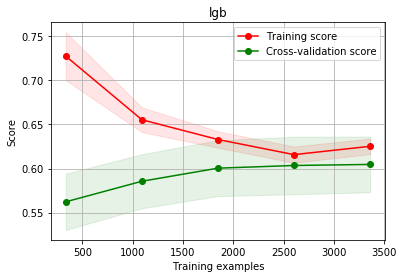

In [81]:
sklearn_model_curve.plot_learning_curve(gbm_model, 'lgb', X_all_train, y_all_train, cv=5)

In [50]:
gbm_model.fit(X_all_train, y_all_train)

y_pred = gbm_model.predict(munged_test_df.values)
output = pd.DataFrame({'id': munged_test_df.index, 'y': y_pred})
output.to_csv('../data/online/lightbgm_outlier__6-26-6_0.604673_0.032991_3.csv', index=False)